In [ ]:
!pip install grad-cam --quiet

# Import Libraries

In [ ]:
# --- Standard ---
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Torch ---
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F

# --- Vision ---
from torchvision import transforms
from PIL import Image

# --- Grad-CAM ---
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# --- Google Drive ---
from google.colab import drive

# Find Paths

In [ ]:
drive.mount('/content/drive')
SPLITS_DIR = "/content/drive/MyDrive/neuro-imaging/splits"
OUT_DIR    = "/content/drive/MyDrive/neuro-imaging/models"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Open Class Information

In [ ]:
with open(os.path.join(SPLITS_DIR, "class_to_idx.json"), "r") as f:
    class_to_idx = json.load(f)
idx_to_class = {v:k for k,v in class_to_idx.items()}
num_classes = len(class_to_idx)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Model

In [ ]:
import timm
ckpt = torch.load(os.path.join(OUT_DIR, "best.pt"), map_location=device)
model = timm.create_model("efficientnet_b0", pretrained=False, num_classes=num_classes)
model.load_state_dict(ckpt["model_state_dict"])
model.eval().to(device)

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2

# Transform

In [ ]:
IMG_SIZE = 224
val_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

# Picking Target Layer for GradCam

In [ ]:
target_layers = [model.conv_head]  # last conv layer works better for CAM
cam = GradCAMPlusPlus(model=model, target_layers=target_layers)

with torch.no_grad():
    logits = model(input_tensor)
    pred_class = int(torch.argmax(logits, 1).item())

grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(pred_class)])[0, :]

# Sample GradCam on a Few Images

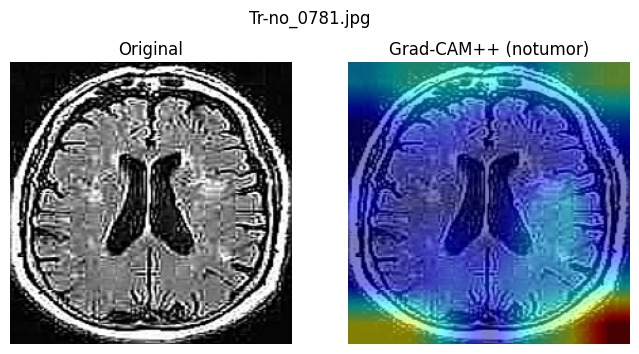

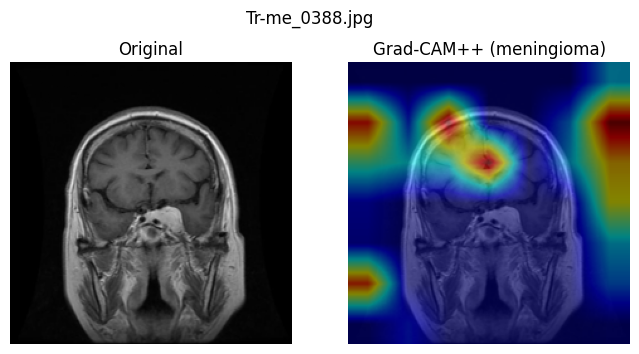

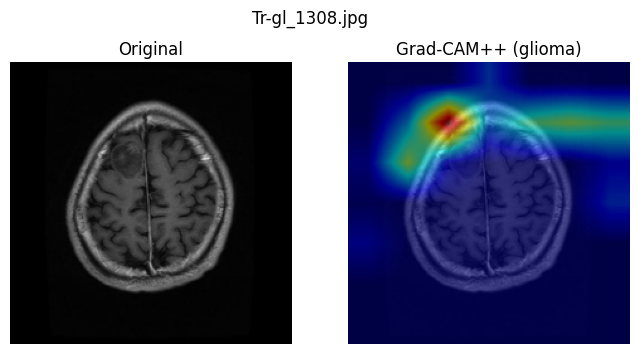

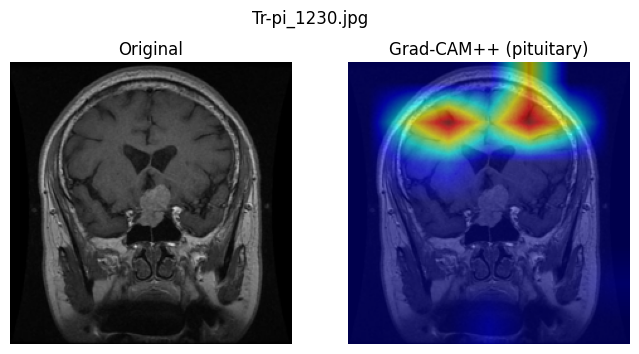

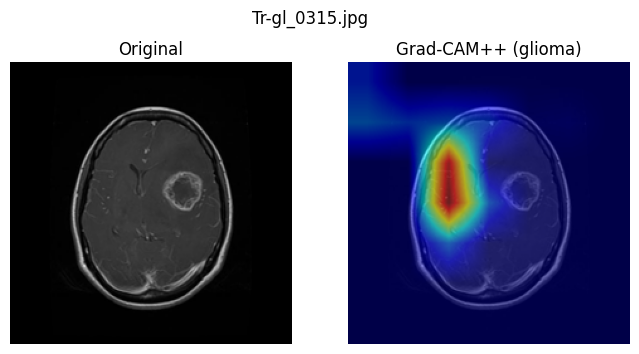

In [ ]:
SAMPLES = 5
sample_paths = []
with open(os.path.join(SPLITS_DIR, "val.txt")) as f:
    sample_paths = [ln.strip() for ln in f][:SAMPLES]

for path in sample_paths:
    img = Image.open(path).convert("RGB")

    # Prepare input tensor
    input_tensor = val_tfms(img).unsqueeze(0).to(device)

    # True class for CAM
    cls_name = os.path.basename(os.path.dirname(path))
    true_label = class_to_idx[cls_name]

    # Run CAM
    grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(true_label)])[0, :]

    # Convert image to float [0,1] for visualization
    rgb_img = np.array(img.resize((IMG_SIZE, IMG_SIZE))).astype(np.float32) / 255.0

    # Overlay CAM
    cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    # Plot
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(rgb_img)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(cam_image)
    plt.title(f"Grad-CAM++ ({cls_name})")
    plt.axis("off")

    plt.suptitle(f"{os.path.basename(path)}")
    plt.show()